In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
# Define paths for train, validation, and test directories
train_dir = '/content/drive/MyDrive/oral cancer dataset/train'
val_dir = '/content/drive/MyDrive/oral cancer dataset/val'
test_dir = '/content/drive/MyDrive/oral cancer dataset/test'

# Data augmentation for training dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [3]:
# Load the pre-trained MobileNetV2 model, exclude top layers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [4]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


Epoch 1/10
155/155 [==============================] - 880s 5s/step - loss: 0.5434 - accuracy: 0.7271 - val_loss: 0.4821 - val_accuracy: 0.7667
Epoch 2/10
155/155 [==============================] - 127s 817ms/step - loss: 0.4349 - accuracy: 0.7970 - val_loss: 0.4886 - val_accuracy: 0.7500
Epoch 3/10
155/155 [==============================] - 127s 816ms/step - loss: 0.3907 - accuracy: 0.8209 - val_loss: 0.4616 - val_accuracy: 0.7833
Epoch 4/10
155/155 [==============================] - 126s 811ms/step - loss: 0.3540 - accuracy: 0.8461 - val_loss: 0.4719 - val_accuracy: 0.7583
Epoch 5/10
155/155 [==============================] - 127s 816ms/step - loss: 0.3195 - accuracy: 0.8603 - val_loss: 0.4704 - val_accuracy: 0.7667
Epoch 6/10
155/155 [==============================] - 126s 816ms/step - loss: 0.3175 - accuracy: 0.8607 - val_loss: 0.5171 - val_accuracy: 0.7833
Epoch 7/10
155/155 [==============================] - 126s 812ms/step - loss: 0.2946 - accuracy: 0.8755 - val_loss: 0.4688 - va

4/4 [==============================] - 33s 10s/step - loss: 0.2991 - accuracy: 0.8492
Test Accuracy: 0.8492063283920288
4/4 [==============================] - 8s 2s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.74      0.71        31
        OSCC       0.91      0.88      0.90        95

    accuracy                           0.85       126
   macro avg       0.79      0.81      0.80       126
weighted avg       0.85      0.85      0.85       126



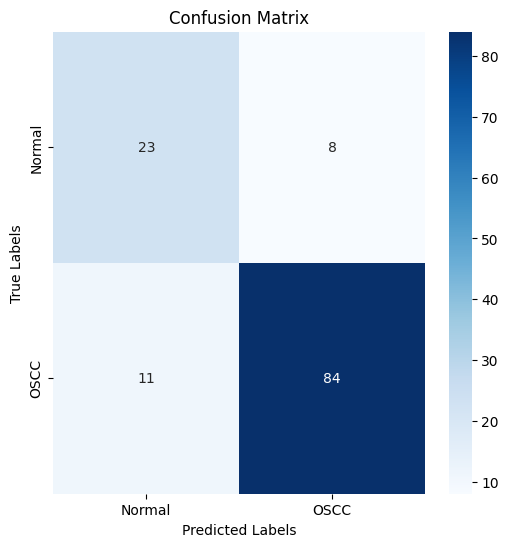

In [5]:
# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Get predictions
test_generator.reset()
preds = model.predict(test_generator)
pred_labels = np.where(preds > 0.5, 1, 0).flatten()  # Assuming binary classification

# Classification Report
print("Classification Report:")
print(classification_report(test_generator.classes, pred_labels, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(test_generator.classes, pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


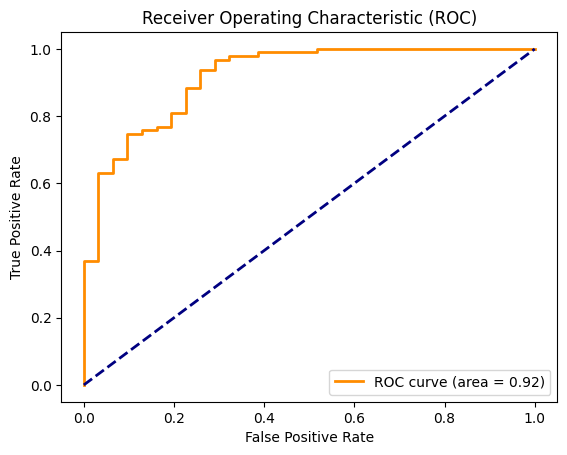

In [6]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


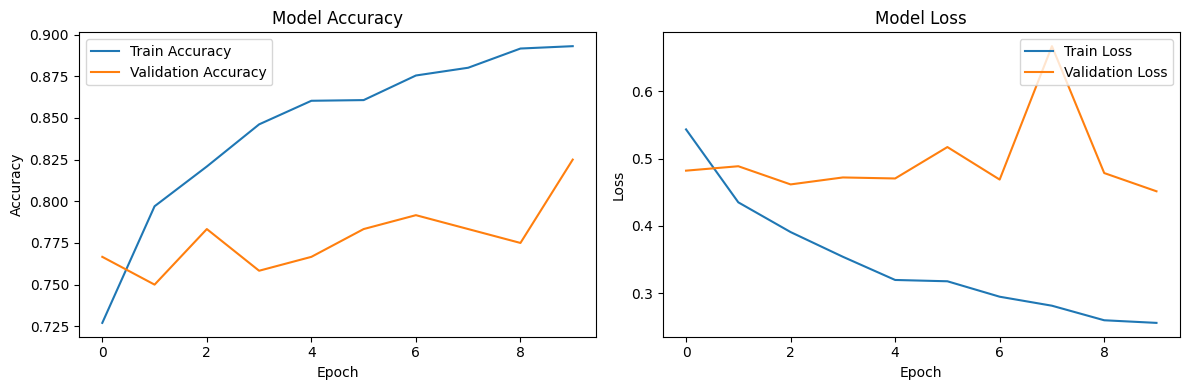

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    if prediction > 0.5:
        print("Prediction: Cancerous")
    else:
        print("Prediction: Non-Cancerous")

# Usage
predict_image('/content/135.jpeg')


1/1 [==============================] - 0s 44ms/step
Prediction: Cancerous


In [10]:
model.save('oral_cancer_detector_p.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Epoch 1/50
155/155 [==============================] - 119s 584ms/step - loss: 0.6859 - accuracy: 0.5596 - val_loss: 0.6403 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 2/50
155/155 [==============================] - 87s 563ms/step - loss: 0.6534 - accuracy: 0.6163 - val_loss: 0.7504 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 3/50
155/155 [==============================] - 88s 565ms/step - loss: 0.6453 - accuracy: 0.6140 - val_loss: 0.5615 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 4/50
155/155 [==============================] - 88s 566ms/step - loss: 0.6139 - accuracy: 0.6551 - val_loss: 0.5984 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 5/50
155/155 [==============================] - 88s 567ms/step - loss: 0.6031 - accuracy: 0.6684 - val_loss: 0.7190 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/50
155/155 [==============================] - 88s 566ms/step - loss: 0.5939 -

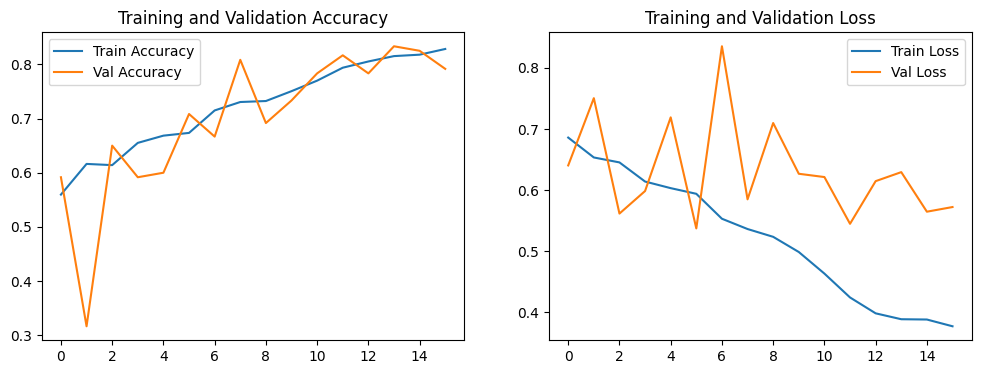

4/4 [==============================] - 6s 2s/step - loss: 0.5214 - accuracy: 0.7222
Test Accuracy: 72.22%
4/4 [==============================] - 6s 2s/step


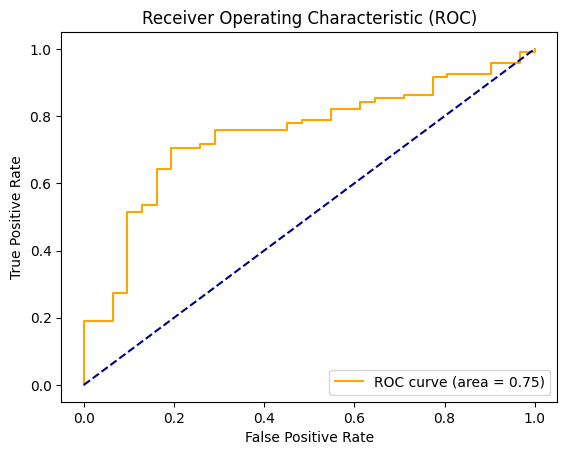

              precision    recall  f1-score   support

      Normal       0.43      0.42      0.43        31
        OSCC       0.81      0.82      0.82        95

    accuracy                           0.72       126
   macro avg       0.62      0.62      0.62       126
weighted avg       0.72      0.72      0.72       126



In [12]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report
import numpy as np
import os

# Set paths
train_dir = '/content/drive/MyDrive/oral cancer dataset/train'
val_dir = '/content/drive/MyDrive/oral cancer dataset/val'
test_dir = '/content/drive/MyDrive/oral cancer dataset/test'

# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the Data
train_data = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='binary')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=32, class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=False)

# Define the Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Save the Model as .h5
model.save('oral_cancer_detector.h5')

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# ROC Curve and AUC Score
y_true = test_data.classes
y_pred = model.predict(test_data).ravel()
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Classification Report
y_pred_class = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred_class, target_names=test_data.class_indices.keys()))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Path to the dataset
data_dir = '/content/drive/MyDrive/oral cancer dataset'

# Define data split configurations
data_splits = [
    {'train_size': 0.6, 'val_size': 0.2, 'test_size': 0.2},
    {'train_size': 0.7, 'val_size': 0.15, 'test_size': 0.15},
    {'train_size': 0.8, 'val_size': 0.1, 'test_size': 0.1},
]

# Create ImageDataGenerators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Define the CNN model architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Evaluate model on different data splits
results = []

for split in data_splits:
    train_size, val_size, test_size = split['train_size'], split['val_size'], split['test_size']

    print(f"\nTraining with Split - Train: {train_size}, Val: {val_size}, Test: {test_size}")

    # Prepare data loaders for each split
    train_data = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    val_data = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

    # Initialize and train the model
    model = create_model()
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model on the validation data
    val_loss, val_accuracy = model.evaluate(val_data)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the model for each configuration
    model_name = f"oral_cancer_model_train{int(train_size*100)}_val{int(val_size*100)}_test{int(test_size*100)}.h5"
    model.save(model_name)

    # Append results for inference
    results.append({
        'train_size': train_size,
        'val_size': val_size,
        'test_size': test_size,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

# Display results for each configuration
for res in results:
    print(f"\nSplit - Train: {res['train_size']}, Val: {res['val_size']}, Test: {res['test_size']}")
    print(f"Validation Loss: {res['val_loss']:.4f}, Validation Accuracy: {res['val_accuracy']:.4f}")

# Plot performance across different data splits
train_sizes = [res['train_size'] for res in results]
val_accuracies = [res['val_accuracy'] for res in results]

plt.plot(train_sizes, val_accuracies, marker='o')
plt.title('Validation Accuracy vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.show()



Training with Split - Train: 0.6, Val: 0.2, Test: 0.2
Found 4154 images belonging to 3 classes.
Found 1038 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
